In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import nltk

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
import pickle
import datetime

import pyproj
from scipy.interpolate import griddata

In [26]:
dataset = pd.read_excel('all_houses08liquidity_new.xlsx',sheet_name=0, header=0)

In [29]:
data=dataset
data=data.loc[~pd.isnull(data['soldPrice'])]

In [30]:
data.head(2)

,BedroomSize,BsmntBedroom,BsmntDen,BsmntDining Rm,BsmntFamily Rm,BsmntKitchen,BsmntLaundry,BsmntLiving Rm,BsmntMstr Bed,DenSize,...,transactionType,transitLevel,unitExposure,waterArea,waterSupply,waterView,year,yrBuilt,zone,zoneAuto
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,152.0,NaN,0.0,NaN,0,2017,1955.0,Zone SE,Zone SE
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,169.0,"E, W",0.0,NaN,0,2017,1999.0,Zone NE,Zone NE


In [31]:
len(dataset)

35390

In [32]:
data['daySoldMilli']=0

for i, row in data.iterrows():    
    print('progress:',i,end="\r")
    d = data.loc[i,'daySold']
    try:
        m = datetime.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S').date().strftime("%s")
        #print(int(m))
        data.loc[i,'daySoldMilli'] = int(m)
    except:
        pass

In [33]:
data['daySoldMilli'].head(3)

0    1499918400
1    1487221200
2    1534824000
Name: daySoldMilli, dtype: int64

In [34]:
wgs84_globe = pyproj.Proj(proj='latlong', ellps='WGS84')
aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84',
                       lat_0=51.0430498278, lon_0=-114.068699725)

In [35]:
for i, row in data.iterrows():
    print('progress:',i,end="\r")
    lon = data.loc[i,'longitude']
    lat = data.loc[i,'latitude']
    try:
        cor = pyproj.transform(wgs84_globe, aeqd,  lon, lat)
        data.loc[i,'longitude'] = cor[0]
        data.loc[i,'latitude'] = cor[1]
    except:
        pass

In [36]:
data[['longitude','latitude']].head(3)

,longitude,latitude
0,3643.293508,-5362.217534
1,6216.072747,4993.414993
2,-1171.180819,-7508.562828


In [11]:
#check outliers
fig, ax = plt.subplots()
ax.scatter(x = data['livingSpaceSquareFootageAG'], y = data['soldPrice'])

In [37]:
#remove outliers
data = data.drop(data[(data['livingSpaceSquareFootageAG']>5000) & (data['soldPrice']<2000000)].index)
data = data.drop(data[(data['livingSpaceSquareFootageAG']<5000) & (data['soldPrice']>3000000)].index)

In [11]:
datafull=data[['soldPrice','longitude','latitude','daySoldMilli']]
#datafull['soldPrice']=np.log1p(datafull['soldPrice'])

In [33]:
datafull = datafull.drop(datafull[(datafull['latitude']>53) | (datafull['longitude']>-111)].index)

In [36]:
datafull.head(2)

,soldPrice,longitude,latitude,daySoldMilli
0,625000,-113.987473,50.892581,1535068800
1,505000,-114.085375,50.975555,1534809600


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


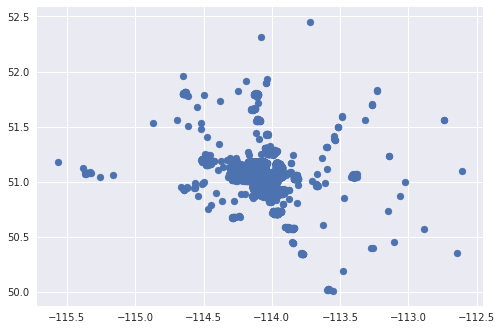

In [37]:
plt.scatter(datafull['longitude'], datafull['latitude'])
plt.show()

In [12]:
datafull.dropna(inplace=True)
datafull=datafull[~pd.isnull(datafull)]
len(datafull)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


11415

In [39]:
datac=datafull.loc[(datafull['soldPrice']<800000)&(datafull['soldPrice']>200000)]
datac['soldPrice']=np.log1p(datac['soldPrice'])

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


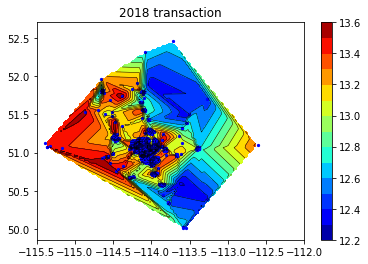

In [75]:
# define grid.
xi = np.linspace(-115.5,-112,100)
yi = np.linspace(50,52.7,100)

# grid the data.
zi = griddata((datac['longitude'], datac['latitude']), datac['soldPrice'], (xi[None,:], yi[:,None]))

# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar

# plot data points.
plt.scatter(datac['longitude'], datac['latitude'],marker='o',c='b',s=5)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.title('2018 transaction')
plt.show()

In [40]:
data1=datac

In [41]:
y=data1['soldPrice']
x=data1.drop(['soldPrice'],1)

In [42]:
len(x)

9936

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [26]:
len(x_test)

0

In [44]:
x_train.head(3)

,longitude,latitude,daySoldMilli
8139,-114.115038,50.897965,1524096000
7465,-113.966550,51.023838,1526947200
7026,-114.099300,51.068442,1528416000


# Model training

## experiment

In [45]:
from pykrige import OrdinaryKriging,UniversalKriging
from pykrige.ok3d import OrdinaryKriging3D

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'exponential' Variogram Model
Partial Sill: 0.0935575414436
Full Sill: 0.150363532948
Range: 1.86369995586
Nugget: 0.0568059915044 



/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


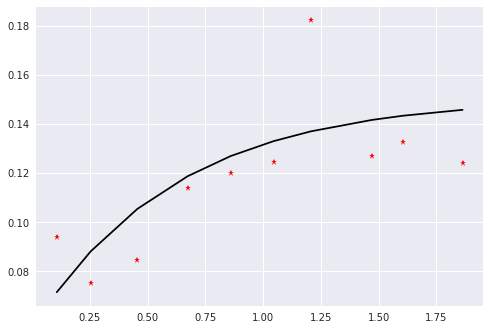

Calculating statistics on variogram model fit...
Q1 = 0.029381722759
Q2 = 1.08019229743
cR = 0.0645092545627 



In [57]:
# Create ordinary kriging object:
OK = OrdinaryKriging(x_train.iloc[:5000]['longitude'], x_train.iloc[:5000]['latitude'], y_train[:5000], 
                     variogram_model='exponential', weight=True, 
                     verbose=True, enable_statistics=True, enable_plotting=True,coordinates_type='geographic',
                     nlags=10)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.09253229775078553
Full Sill: 0.14770141003630538
Range: 1.9707004685156508
Nugget: 0.05516911228551984 



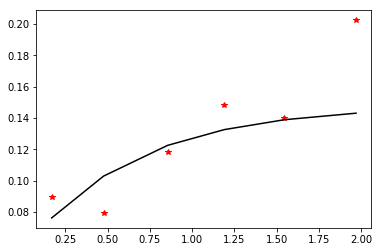

Calculating statistics on variogram model fit...
Q1 = 0.028546552157531862
Q2 = 1.0934264415281714
cR = 0.06378644927863912 

Initializing drift terms...
Implementing regional linear drift.


In [100]:
# Create universal kriging object:
UK = UniversalKriging(x_train.iloc[:5000]['longitude'], x_train.iloc[:5000]['latitude'], y_train[:5000], 
                      variogram_model='exponential', 
                      weight=True,  
                      verbose=True, enable_plotting=True,
                      drift_terms=['regional_linear'])

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.00389187727705
Full Sill: 0.0855785170457
Range: 19448975.6195
Nugget: 0.0816866397687 



/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


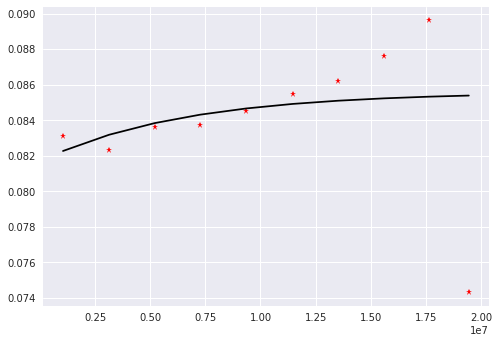

Calculating statistics on variogram model fit...
Q1 = 0.00286833496401
Q2 = 1.01488626389
cR = 0.0844924941899 



In [55]:
# 3d OrdinaryKriging
OK = OrdinaryKriging3D(x_train.iloc[:1000]['longitude'], x_train.iloc[:1000]['latitude'], x_train.iloc[:1000]['daySoldMilli'], 
                     y_train[:1000], variogram_model='linear', weight=True, 
                     verbose=True, enable_plotting=True,nlags=10)

AttributeError: 'NoneType' object has no attribute 'size'

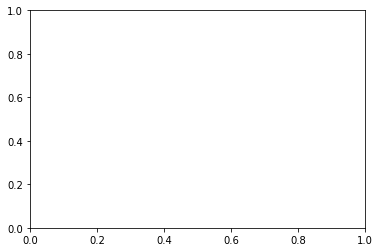

In [71]:
OK.plot_epsilon_residuals()

In [83]:
#Execute on grid:
y_pred, y_std = OK.execute('grid', x_test.iloc[1]['longitude'], x_test.iloc[1]['latitude'])

Executing Ordinary Kriging...



In [87]:
np.expm1(y_test.iloc[1])

286250.0000000002

In [90]:
np.expm1(y_pred)

masked_array(data=[[466038.4708176095]],
             mask=[[False]],
       fill_value=1e+20)

## clean data for regression

In [42]:
def spacial_model_dataclean(rawdata): 
    
    english_stemmer = nltk.stem.SnowballStemmer('english')
    if type(rawdata) is dict:
        dataset=pd.DataFrame.from_dict(rawdata,orient="index").T
     
    elif type(rawdata) is list:
        # if load data from dynamo
        dataset= pd.DataFrame(rawdata)
        
        # remove duplicates
        dataset=dataset.drop_duplicates(subset=['address','daySold'], keep='first')
    else:
        dataset=rawdata
    
    dataset=dataset[~pd.isnull(dataset['daySold'])]
    dataset=dataset[~pd.isnull(dataset['yrBuilt'])]
    dataset=dataset[~pd.isnull(dataset['soldPrice'])]
    data=dataset
    #data['soldPrice']=data['priceAdjusted']
    
    var=['bathroomsFull','bathroomsHalf','bedroomsAG','bedroomsTotal','enclosedParking','totalParking','yrBuilt',
         'livingSpaceSquareFootageAG', 'soldPrice','trafficLevel','trafficSignal','attraction','latitude','longitude',
         'age','taxAmount',"lotSizeSquareMetres",'daySoldMilli','waterArea','playgroundArea','parkArea','golfArea',
         'transitLevel','mlsIndex']
         
        # 'mlsIndex','gdp','year','month','salesToListing',
 
    
    col=[]
    for i in data.columns:
        if i in var:
            col.append(i)
    data=data[col]
    data=data[~data['soldPrice'].isna()]
    
    #data['compsCurrent']=data['compsCurrent'].fillna(data['compsCurrent'].mean())
    data=data.fillna(0)
    data=data.convert_objects(convert_numeric=True)
    data.replace('NaN',0)
    
    # one-hot encoding 
    #('parking','basement','buildingType','style','flooring','fireplace','heatingType','exterior','roofType',
    #'frontExposure','foundation','constructionType','heatingFuel)
    isBuildingType = pd.get_dummies(dataset['buildingType'],prefix='buildingType')
    isStyle = pd.get_dummies(dataset['style'],prefix='style')
   
    isBasement_Walkout= pd.DataFrame(dataset['basement'].str.contains('Walkout')*1)
    isBasement_Walkout.columns=['basementWalkout']
    
    Land_R1= pd.DataFrame(dataset['landUseCode'].str.contains("R.*1.*")*1)
    Land_R1.columns=['landCodeR1']
    Land_R2= pd.DataFrame(dataset['landUseCode'].str.contains("R.*2.*")*1)
    Land_R2.columns=['landCodeR2']
    Land_M= pd.DataFrame(dataset['landUseCode'].str.startswith('M')*1)
    Land_M.columns=['landCodeM']
    
    
    parking_list=['Attached','Detached','Parking Pad','Rear Drive Access','RV Parking',
                 'Outdoor Stalls','220 Volt Wiring']
    parking_dataframe=pd.DataFrame()
    for d in parking_list:

        parking_d= pd.DataFrame(dataset['parking'].str.contains(d)*1)
        parking_d.columns=[f'parking{d}']

        if parking_dataframe.empty:
            parking_dataframe= parking_dataframe.append(parking_d)
        else:
            parking_dataframe= parking_dataframe.join(parking_d)

            
    basement_list=['Partly Finished', 'Fully Finished', 'Suite']
    basement_dataframe=pd.DataFrame()
    for d in basement_list:

        basement_d= pd.DataFrame(dataset['basementDevelopment'].str.contains(d)*1)
        basement_d.columns=[f'basement{d}']

        if basement_dataframe.empty:
            basement_dataframe= basement_dataframe.append(basement_d)
        else:
            basement_dataframe= basement_dataframe.join(basement_d) 
    
    
    heatingType_list=['In Floor Heat System']
    heatingType_dataframe=pd.DataFrame()
    for d in heatingType_list:

        heatingType_d= pd.DataFrame(dataset['heatingType'].str.contains(d)*1)
        heatingType_d.columns=[f'heatingType{d}']

        if heatingType_dataframe.empty:
            heatingType_dataframe= heatingType_dataframe.append(heatingType_d)
        else:
            heatingType_dataframe= heatingType_dataframe.join(heatingType_d)
   
    
    exterior_list=['Brick', 'Composite' , 'Stucco', 'Fiber Cement Siding', 'Stone', 'Metal', 'Wood','Concrete',
                   'Asbestos', 'Cedar', 'Vinyl', 'Shingles', 'Log','Asphalt Shingles','Wood Shingle'] 
    exterior_dataframe=pd.DataFrame()
    for d in exterior_list:

        exterior_d= pd.DataFrame(dataset['exterior'].str.contains(d)*1)
        exterior_d.columns=[f'exterior{d}']

        if exterior_dataframe.empty:
            exterior_dataframe= exterior_dataframe.append(exterior_d)
        else:
            exterior_dataframe= exterior_dataframe.join(exterior_d)
    
    flooring_list=['Carpet', 'Laminate Flooring', 'Linoleum','Hardwood','Ceramic Tile','Slate',
                   ' Non-Ceramic Tile','Wall to Wall Carpet','Carpet Over Hardwood','Cork Flooring',
                   'Marble','Softwood','Carpet Over Softwood'] 
    flooring_dataframe=pd.DataFrame()
    for d in flooring_list:

        flooring_d= pd.DataFrame(dataset['flooring'].str.contains(d)*1)
        flooring_d.columns=[f'flooring{d}']

        if flooring_dataframe.empty:
            flooring_dataframe= flooring_dataframe.append(flooring_d)
        else:
            flooring_dataframe= flooring_dataframe.join(flooring_d)
    
 
    
    data= data.join([isBuildingType,isStyle,
                     parking_dataframe,isBasement_Walkout,
                     Land_R1,Land_R2,Land_M, basement_dataframe,
                     heatingType_dataframe,exterior_dataframe,
                    flooring_dataframe])
    

    
    data=data.fillna(data.mean())
    data.loc[data['age']<=0,'age']=0
    col_name=['age', 'bathroomsFull', 'bathroomsHalf', 'bedroomsAG', 'bedroomsTotal', 'enclosedParking', 
              'livingSpaceSquareFootageAG', 'soldPrice', 'totalParking', 
              'taxAmount','lotSizeSquareMetres',
              'parkingAttached','parkingDetached','longitude', 'latitude','daySoldMilli',
              'parkingRear Drive Access','parkingParking Pad','parkingRV Parking','parkingOutdoor Stalls',
              'parking220 Volt Wiring',
              'yrBuilt', 'buildingType_Detached', 
              'buildingType_Double Wide', 'buildingType_High Rise Apartment', 'buildingType_Lowrise Apartment', 
              'buildingType_Row', 'buildingType_Semi Detached', 'buildingType_Single Wide', 'style_1 & Half St', 
              'style_2 & Half St', 'style_2 Storey', 'style_2 Sty Split', 'style_3 Lvl Split', 'style_3 Storey', 
              'style_4 Lvl Split', 'style_5 Lvl Split', 'style_Bi-Level', 'style_Bungalow', 'style_Dbl Wide Mob Hm', 
              'style_Loft', 'style_Modular Home', 'style_Not Applicable', 'style_Single Level Unit', 
              'style_Sng Wide Mob Hme', 'style_Stacked Townhouse',  'basementWalkout',
              'basementFully Finished', 'basementSuite',
              'basementPartly Finished', 'landCodeR1', 'landCodeR2', 'landCodeM',  'heatingTypeIn Floor Heat System', 
              'exteriorComposite', 'exteriorStucco', 
              'exteriorFiber Cement Siding', 'exteriorStone', 'exteriorMetal', 'exteriorWood', 'exteriorConcrete', 
              'exteriorAsbestos', 'exteriorCedar', 'exteriorVinyl', 'exteriorShingles', 'exteriorLog', 
              'exteriorAsphalt Shingles', 'exteriorWood Shingle', 
              'flooringCarpet', 'flooringLaminate Flooring', 'flooringLinoleum', 'flooringHardwood', 'flooringCeramic Tile', 
              'flooringSlate', 'flooring Non-Ceramic Tile', 'flooringWall to Wall Carpet', 'flooringCarpet Over Hardwood', 
              'flooringCork Flooring', 'flooringMarble', 'flooringSoftwood', 'flooringCarpet Over Softwood',
              'waterArea','playgroundArea','parkArea','golfArea', 'transitLevel','mlsIndex']
     
    
    for i in col_name:
        if i not in data.columns:
            data[i]=0
    
    data=data[col_name]   
    
            
#     data['community']=dataset['communityAuto']

#     data['baseDescription']=dataset['baseDescription']       
#     data['baseDescription']=data['baseDescription'].str.lower()
    

#     renovation_searchfor=['renov','improv','refinish','upgrad','updat']
#     renovation_dataframe=pd.DataFrame(data['baseDescription'].str.contains('|'.join(renovation_searchfor))*1)
#     #print(renovation_dataframe)
    
#     renovation_dataframe.columns=['renovation']
#     renovation_dataframe=renovation_dataframe.astype(float)

#     data=data.join([renovation_dataframe])
#     data=data.drop(['baseDescription'], 1)
    
    return data

In [46]:
clean_data=spacial_model_dataclean(data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [47]:
clean_data[['longitude','latitude','daySoldMilli','year']].head(3)

,longitude,latitude,daySoldMilli,year
0,3643.293508,-5362.217534,1499918400,2017
1,6216.072747,4993.414993,1487221200,2017
2,-1171.180819,-7508.562828,1534824000,2018


In [49]:
writer = pd.ExcelWriter('clean_data2018.xlsx')
clean_data.to_excel(writer,'clean_data2018')

In [207]:
cor=clean_data[['longitude','latitude']]
clean_data1=clean_data.drop(['longitude','latitude'],1)

In [208]:
clean_data1=np.log1p(clean_data1)
clean_data=clean_data1.join(cor)

In [209]:
Y=clean_data['soldPrice']
X=clean_data.drop(['soldPrice'],1)

## model

In [162]:
import sys

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split
import xgboost

In [210]:
#svr_model = SVR(C=0.1,gamma='auto', kernel='rbf',shrinking=True)
#rf_model = RandomForestRegressor(n_estimators=100)
xg_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05, gamma=0.1, subsample=0.9,max_depth=9)
lr_model = linear_model.Ridge(copy_X=True, alpha=0.001,fit_intercept=False)

models = [ xg_model, lr_model]

In [211]:
# take the first 5000 as Kriging is memory intensive
p = X.drop(['longitude','latitude','daySoldMilli'],1)
cordinate = X[['longitude','latitude','daySoldMilli']].values
target = Y
p_train, p_test, cordinate_train, cordinate_test, target_train, target_test \
    = train_test_split(p, cordinate, target, test_size=0.2, random_state=42)

In [193]:
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10,variogram_model='exponential', 
                             weight=True,verbose=True,method='ordinary3d')
    m_rk.fit(p_train, cordinate_train, target_train)
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, cordinate_test, target_test))

regression model: XGBRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.9220250877184338
RK score:  0.9226812553980155
regression model: Ridge
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7113692459927574
RK score:  0.7316776580976936


In [ ]:
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=20,variogram_model='exponential', 
                             weight=True,verbose=True,method='ordinary3d')
    m_rk.fit(p_train, cordinate_train, target_train)
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, cordinate_test, target_test))

regression model: XGBRegressor
Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.03337948302367471
Full Sill: 0.03683140268712038
Range: 580208.4688132132
Nugget: 0.0034519196634456737 

Calculating statistics on variogram model fit...
Q1 = 0.0026983671160513913
Q2 = 1.6458121535586479
cR = 0.006071898912307925 

Finished kriging residuals
Regression Score:  0.9214216678121514
Executing Ordinary Kriging...

RK score:  0.9287545314084936
regression model: Ridge
Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.0001899872013953713
Full Sill: 0.03139653987751212
Range: 0.8155860130837027
Nugget: 0.031206552676116748 

Calculating statistics on variogram model fit...
